In [1]:
import pandas as pd
import numpy as np
import os
import pickle

In [2]:
'''NOTE: some names don't match as they have the '.' character
'''

electors_df = pd.read_csv('2021_11_Presidencial/output/2021_11_Presidencial_ELECTORES.csv')
# in CIRCUNSCRIPCION ELECTORAL, replace '.' with ''
electors_df['CIRCUNSCRIPCION ELECTORAL'] = electors_df['CIRCUNSCRIPCION ELECTORAL'].str.replace('.', '')

In [3]:
def age_group_to_index(age_group):
    index_list = []
    start_numbers = [18, 20, 30, 40, 50, 60, 70, 80]
    end_numbers = [19, 29, 39, 49, 59, 69, 79]
    # check if there's a plus
    if '+' in age_group:
        age_group = age_group.split('+')
        age_group[0] = int(age_group[0])
        # see where is located in start_numbers
        for i in range(len(start_numbers)):
            if age_group[0] == start_numbers[i]:
                index_list.extend(range(i,len(start_numbers)))
                break
        return index_list
    # separate by - and transform to int
    age_group = age_group.split('-')
    age_group = list(map(int, age_group))
    # get the index of the start and end numbers
    for i in range(len(start_numbers)):
        if age_group[0] == start_numbers[i]:
            index_list.append(i)
            break
    for i in range(len(end_numbers)):
        if age_group[1] == end_numbers[i]:
            # if not in list, append all indexes before
            if i not in index_list:
                index_list.extend(range(index_list[0]+1,i+1))
            break
    return index_list

In [4]:
regions = ["DE ARICA Y PARINACOTA",
           "DE TARAPACA", 
           "DE ANTOFAGASTA",
           "DE ATACAMA",
           "DE COQUIMBO",
           "DE VALPARAISO",
           "METROPOLITANA DE SANTIAGO",
           "DEL LIBERTADOR GENERAL BERNARDO O'HIGGINS",
           "DEL MAULE",
           "DE NUBLE",
           "DEL BIOBIO",
           "DE LA ARAUCANIA",
           "DE LOS RIOS",
           "DE LOS LAGOS",
           "DE AYSEN DEL GENERAL CARLOS IBANEZ DEL CAMPO",
           "DE MAGALLANES Y DE LA ANTARTICA CHILENA"]

In [5]:
region_labels = ['AP', 'TA', 'AN', 'AT', 'CO', 'VA', 'RM', 'LI', 'ML', 'NB', 'BI', 'AR', 'LR', 'LL', 'AI', 'MA']

In [6]:
output_file = '2021_11_Presidencial/output'
# get all folders in output_file
# regions = [f for f in os.listdir(output_file) if os.path.isdir(os.path.join(output_file, f))]

AGE_GROUPS = ['18-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

# read output/CANDIDATOS.pickle
with open('2021_11_Presidencial/output/CANDIDATOS.pickle', 'rb') as f:
    candidatos = pickle.load(f)


boric_heatmap = np.zeros((len(AGE_GROUPS), len(regions)))
kast_heatmap = np.zeros((len(AGE_GROUPS), len(regions)))
parisi_heatmap = np.zeros((len(AGE_GROUPS), len(regions)))

# loop over regions
for r in regions:
    # print(r)
    region_path = os.path.join(output_file, r)
    # get all districts in region file
    districts = [f for f in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, f))]

    tota_electors_in_region = np.zeros(len(AGE_GROUPS))
    total_weighted_in_region = np.zeros(len(AGE_GROUPS))    

    # weighted_probs_in_region = np.zeros(len(AGE_GROUPS))
    weighted_boric = np.zeros(len(AGE_GROUPS))
    weighted_kast = np.zeros(len(AGE_GROUPS))
    weighted_parisi = np.zeros(len(AGE_GROUPS))
    for d in districts:

        # print(d)
        # get GRUPOS.pickle from district
        district_path = os.path.join(region_path, d)

        with open(os.path.join(district_path, 'GRUPOS.pickle'), 'rb') as f:
            grupos_d = pickle.load(f)
        probs = pd.read_csv(os.path.join(district_path, f'P_{d}.csv'), index_col=0)
        df_district = pd.read_csv(os.path.join(district_path, f'{d}.csv'))
        

        
        # which column is GABRIEL BORIC and JOSE ANTONIO KAST
        idx_boric = candidatos.index('GABRIEL BORIC')
        idx_kast = candidatos.index('JOSE ANTONIO KAST')
        idx_parisi = candidatos.index('FRANCO ALDO PARISI')

        # define matrices
        probs_matrix = probs.values
        electors_matrix_agg = df_district[grupos_d].values
        electors_agg_sum = electors_matrix_agg.sum(axis=0)

        district_fixed_name = d.replace('.', '') # shouldn't need to do this, but there's 3 mismatched names
        electors_district = electors_df[electors_df['CIRCUNSCRIPCION ELECTORAL'] == district_fixed_name]
        electors_matrix = electors_district[AGE_GROUPS].values
        
        # get sum of electors (each column)
        electors_sum = electors_matrix.sum(axis=0)

        # add to total electors in region
        tota_electors_in_region += electors_sum

        # get index from probs
        index = probs.index
        # get index_list
        group_indexes = [age_group_to_index(i) for i in index]

        # weighted electors sum
        electors_weighted_sum = np.zeros(len(AGE_GROUPS))
        for i in range(len(group_indexes)):
            total_macro_group = np.sum(electors_sum[group_indexes[i]])
            if total_macro_group == 0:
                print(grupos_d)
                print('group_indexes', group_indexes)
                print('district', d)
                print('region', r) 
                print('age_group', index[i])
                print('--')
            else:
                electors_weighted_sum[group_indexes[i]] = electors_sum[group_indexes[i]] / total_macro_group
        total_weighted_in_region += electors_weighted_sum

        # create new empty prob matrix with original age groups
        new_probs_matrix = np.zeros((len(AGE_GROUPS), probs_matrix.shape[1]))
        # loop over group_indexes so that grouped indexes have the same probability
        for i in range(len(group_indexes)):
            new_probs_matrix[group_indexes[i]] = probs_matrix[i]
    
        # probs boric
        probs_boric = new_probs_matrix[:, idx_boric]
        # probs kast
        probs_kast = new_probs_matrix[:, idx_kast]
        # probs paris
        probs_parisi = new_probs_matrix[:, idx_parisi]

        # use weighted sum of electors
        weighted_boric += electors_weighted_sum * probs_boric
        weighted_kast += electors_weighted_sum * probs_kast
        weighted_parisi += electors_weighted_sum * probs_parisi

        # weighted_boric += electors_sum * probs_boric
        # weighted_kast += electors_sum * probs_kast
        # weighted_parisi += electors_sum * probs_parisi
        # weighted_probs_in_region += electors_sum * probs_matrix.sum(axis=1)
        
    # get final probabilities for region
    prob_region_boric = weighted_boric / total_weighted_in_region
    prob_region_kast = weighted_kast / total_weighted_in_region
    prob_region_parisi = weighted_parisi / total_weighted_in_region


    # orininal way 
    # prob_region_boric = weighted_boric / tota_electors_in_region
    # prob_region_kast = weighted_kast / tota_electors_in_region
    # prob_region_parisi = weighted_parisi / tota_electors_in_region

    # add to heatmaps
    boric_heatmap[:, regions.index(r)] = prob_region_boric
    kast_heatmap[:, regions.index(r)] = prob_region_kast
    parisi_heatmap[:, regions.index(r)] = prob_region_parisi
    


In [7]:
### dos decimales
### un grafico para dos candidatos

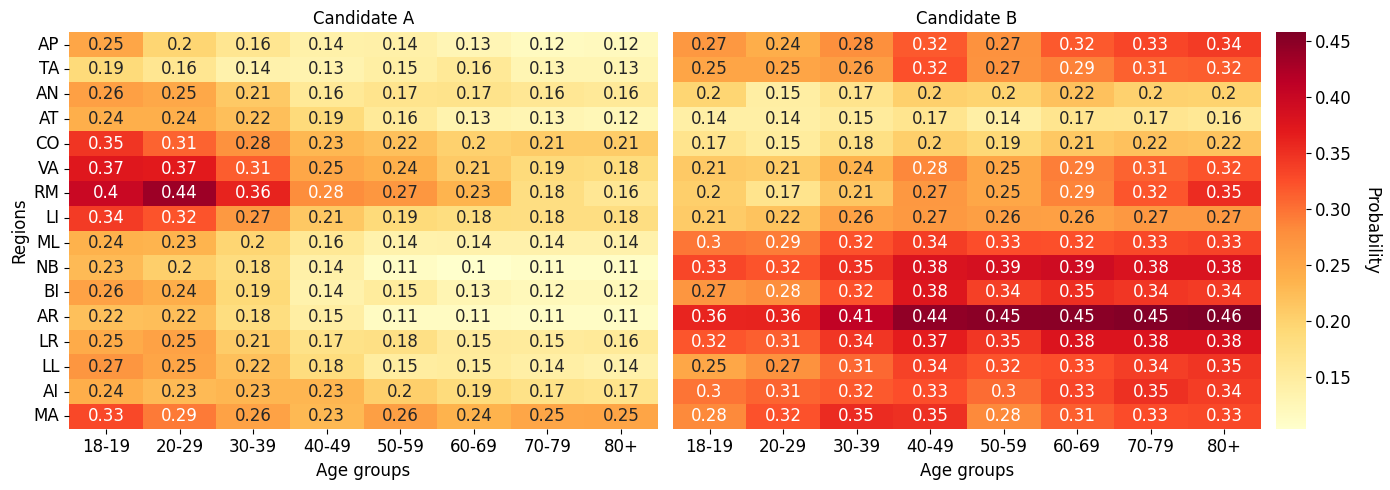

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# sns.heatmap(boric_heatmap.T, annot=True, xticklabels=AGE_GROUPS, yticklabels=region_labels)


# Create a figure with a specific gridspec
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
cbar_ax = plt.subplot(gs[2])

# Find global min and max for the heatmaps to have the same scale
vmin = min(boric_heatmap.min().min(), kast_heatmap.min().min())
vmax = max(boric_heatmap.max().max(), kast_heatmap.max().max())

# Heatmap for Gabriel Boric
sns.heatmap(boric_heatmap.T, annot=True, xticklabels=AGE_GROUPS,
             yticklabels=region_labels, ax=ax0, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax, cmap = 'YlOrRd')
ax0.set_title('Candidate A', fontsize=12)

# Heatmap for José Antonio Kast
sns.heatmap(kast_heatmap.T, annot=True, xticklabels=AGE_GROUPS, 
            yticklabels=region_labels, ax=ax1, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax, cmap = 'YlOrRd')
ax1.set_title('Candidate B', fontsize=12)

# Make y-axis labels only appear on the left plot
ax1.set_yticks([])
# rotate y-ticks
plt.setp(ax0.get_yticklabels(), rotation=0)

# y axis label
ax0.set_ylabel('Regions', fontsize=12)
# set x axis label
ax0.set_xlabel('Age groups', fontsize=12)
ax1.set_xlabel('Age groups', fontsize=12)

# all fontsize to 12
plt.setp(ax0.get_xticklabels(), fontsize=12)
plt.setp(ax0.get_yticklabels(), fontsize=12)
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
# text inside squares
plt.setp(ax0.texts, fontsize=12)
plt.setp(ax1.texts, fontsize=12)
# cbar fontsize
cbar_ax.yaxis.set_tick_params(labelsize=12)

# label for cbar
cbar_ax.set_ylabel('Probability', fontsize=12, labelpad=20, rotation=270)

# Adjust layout
plt.tight_layout()

# save
plt.savefig('images/heatmap_regions_formula_2.png', dpi=400)


plt.show()

<Axes: >

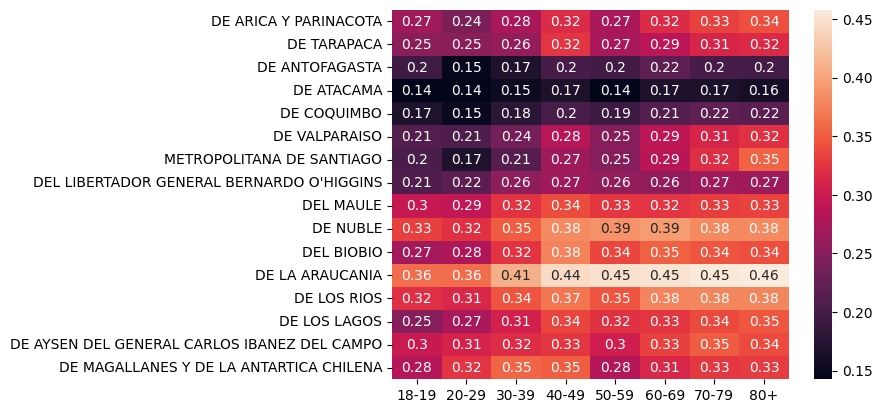

In [9]:
sns.heatmap(kast_heatmap.T, annot=True, xticklabels=AGE_GROUPS, yticklabels=regions)

<Axes: >

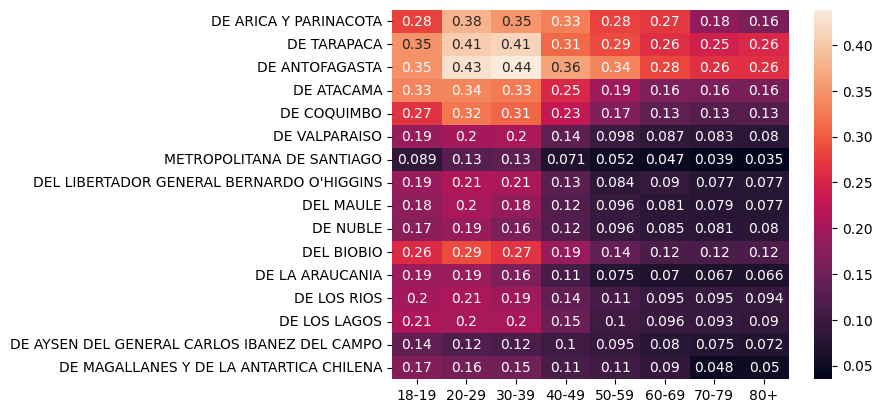

In [10]:
sns.heatmap(parisi_heatmap.T, annot=True, xticklabels=AGE_GROUPS, yticklabels=regions)